In [8]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_curve, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [9]:
train_dir = '/kaggle/input/wildfire-prediction-dataset/train'
valid_dir = '/kaggle/input/wildfire-prediction-dataset/valid'
test_dir = '/kaggle/input/wildfire-prediction-dataset/test'

# Image data generators with data augmentation and shuffling
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Split data for validation
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary',
    shuffle=True,  # Shuffle 
    subset='training'  
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary',
    subset='validation' 
)

Found 24200 images belonging to 2 classes.
Found 6050 images belonging to 2 classes.


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=80,
    epochs=15,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=[reduce_lr]
)

Epoch 1/15
80/80 [==============================] - 43s 521ms/step - loss: 1.2045 - accuracy: 0.6750 - val_loss: 0.5429 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 2/15
80/80 [==============================] - 41s 511ms/step - loss: 0.3985 - accuracy: 0.8313 - val_loss: 0.3850 - val_accuracy: 0.8712 - lr: 0.0010
Epoch 3/15
80/80 [==============================] - 41s 508ms/step - loss: 0.4431 - accuracy: 0.8336 - val_loss: 0.2523 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 4/15
80/80 [==============================] - 40s 508ms/step - loss: 0.4040 - accuracy: 0.8585 - val_loss: 0.3094 - val_accuracy: 0.8988 - lr: 0.0010
Epoch 5/15
80/80 [==============================] - 40s 500ms/step - loss: 0.5579 - accuracy: 0.8148 - val_loss: 0.4477 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 6/15
80/80 [==============================] - 40s 499ms/step - loss: 0.3093 - accuracy: 0.8820 - val_loss: 0.1934 - val_accuracy: 0.9337 - lr: 0.0010
Epoch 7/15
80/80 [==============================] - 39s 492ms/st

In [12]:
model.save('forest_fire_model.h5')

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 128)     

In [14]:
test_dir = '/kaggle/input/wildfire-prediction-dataset/test'  # Provide the path to your test dataset
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary',
    shuffle=False  # Don't shuffle test data
)

Found 6300 images belonging to 2 classes.


In [15]:
test_results = model.evaluate(test_generator, steps=50)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

50/50 [==============================] - 6s 114ms/step - loss: 0.0757 - accuracy: 0.9663
Test Loss: 0.0756722167134285
Test Accuracy: 0.9662500023841858


In [16]:
test_generator.reset()
y_pred = model.predict(test_generator)
y_true = test_generator.classes
confusion = confusion_matrix(y_true, y_pred > 0.5)
print("Confusion Matrix:")
print(confusion)

394/394 [==============================] - 42s 107ms/step
Confusion Matrix:
[[2672  148]
 [ 430 3050]]


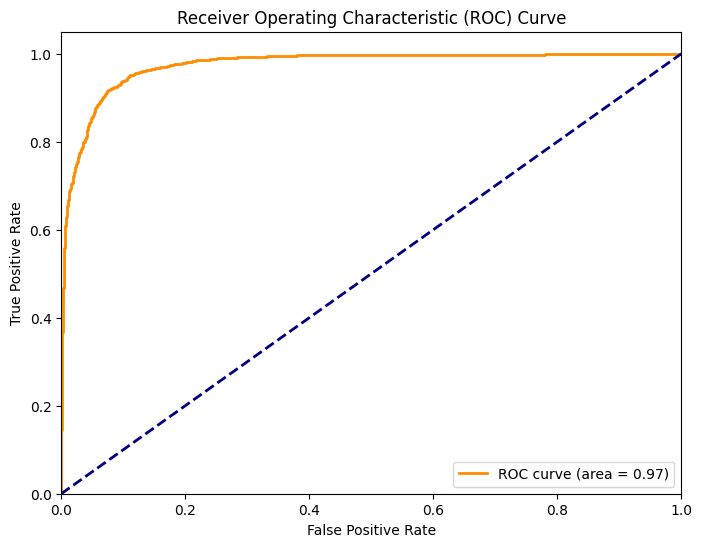

In [67]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

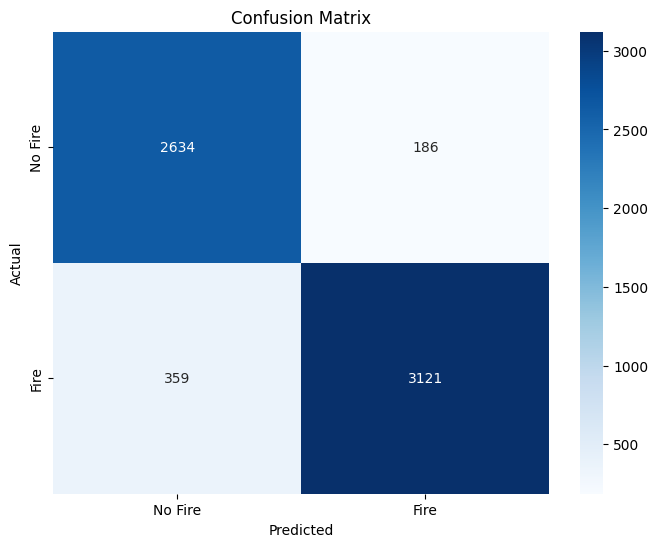

In [56]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred > 0.5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

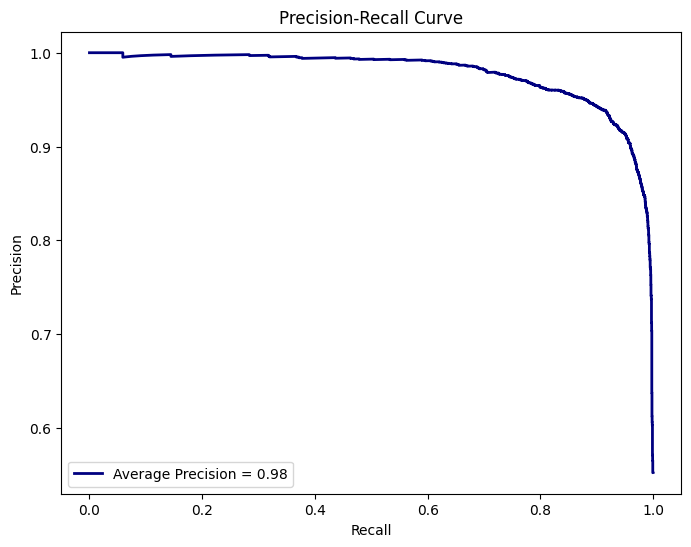

In [63]:
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# Compute average precision
average_precision = average_precision_score(y_true, y_pred)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, lw=2, color='navy', label=f'Average Precision = {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

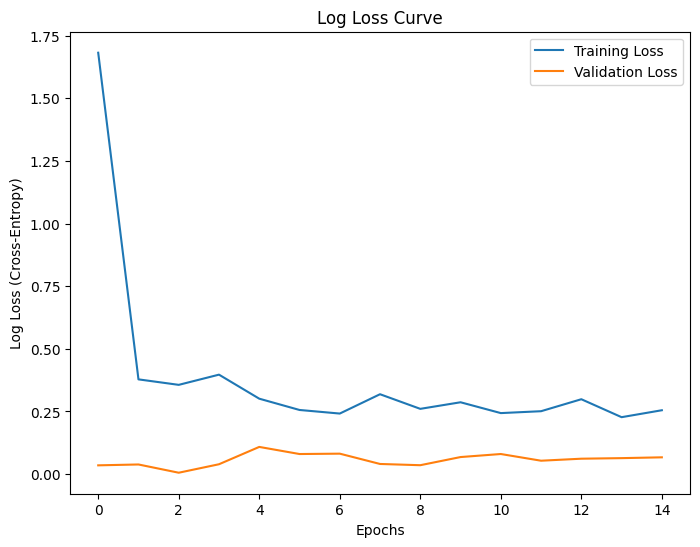

In [65]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss (Cross-Entropy)')
plt.title('Log Loss Curve')
plt.legend()
plt.show()

In [17]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [18]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [19]:
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer=Adam(lr=0.001),  # You can adjust the learning rate as needed
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=60
)

Epoch 1/15
100/100 [==============================] - 50s 498ms/step - loss: 0.3756 - accuracy: 0.8512 - val_loss: 0.2955 - val_accuracy: 0.8760
Epoch 2/15
100/100 [==============================] - 49s 492ms/step - loss: 0.3868 - accuracy: 0.8456 - val_loss: 0.3222 - val_accuracy: 0.8740
Epoch 3/15
100/100 [==============================] - 49s 489ms/step - loss: 0.3692 - accuracy: 0.8544 - val_loss: 0.2935 - val_accuracy: 0.8719
Epoch 4/15
100/100 [==============================] - 49s 496ms/step - loss: 0.3417 - accuracy: 0.8594 - val_loss: 0.3339 - val_accuracy: 0.8604
Epoch 5/15
100/100 [==============================] - 48s 486ms/step - loss: 0.3826 - accuracy: 0.8413 - val_loss: 0.4535 - val_accuracy: 0.8083
Epoch 6/15
100/100 [==============================] - 49s 495ms/step - loss: 0.3644 - accuracy: 0.8562 - val_loss: 0.2962 - val_accuracy: 0.8813
Epoch 7/15
100/100 [==============================] - 49s 489ms/step - loss: 0.3791 - accuracy: 0.8506 - val_loss: 0.3214 - val_ac

In [29]:
model.save('forest_fire_resnetmodel.h5')

In [31]:
test_results = model.evaluate(test_generator, steps=50)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

50/50 [==============================] - 2s 46ms/step - loss: 0.2165 - accuracy: 0.8925
Test Loss: 0.2164553701877594
Test Accuracy: 0.8924999833106995


394/394 [==============================] - 24s 59ms/step
Confusion Matrix:
[[2496  324]
 [ 480 3000]]


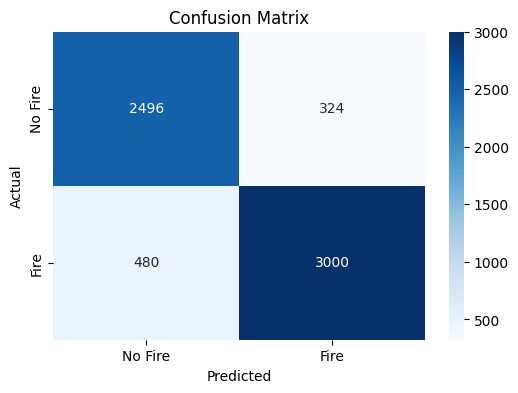

In [32]:
test_generator.reset()
y_pred = model.predict(test_generator)
y_true = test_generator.classes
confusion = confusion_matrix(y_true, y_pred > 0.5)
print("Confusion Matrix:")
print(confusion)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Log Loss: 0.34385764414857656


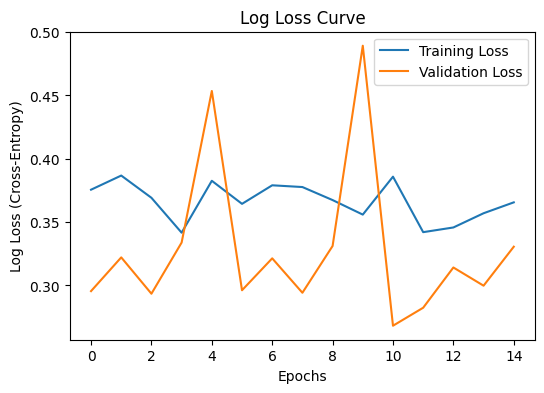

In [33]:

logloss = log_loss(y_true, y_pred)
print("Log Loss:", logloss)

# Log loss curve
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss (Cross-Entropy)')
plt.title('Log Loss Curve')
plt.legend()
plt.show()

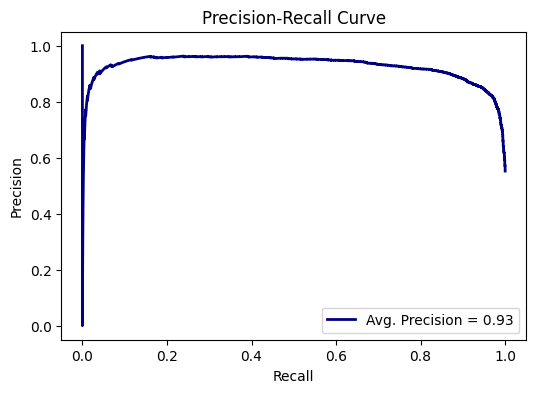

In [34]:
# Precision-recall curve and average precision
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
average_precision = average_precision_score(y_true, y_pred)

# Plot precision-recall curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, lw=2, color='navy', label=f'Avg. Precision = {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [35]:
test_generator.reset()
y_pred = model.predict(test_generator)
y_true = test_generator.classes
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

394/394 [==============================] - 20s 51ms/step


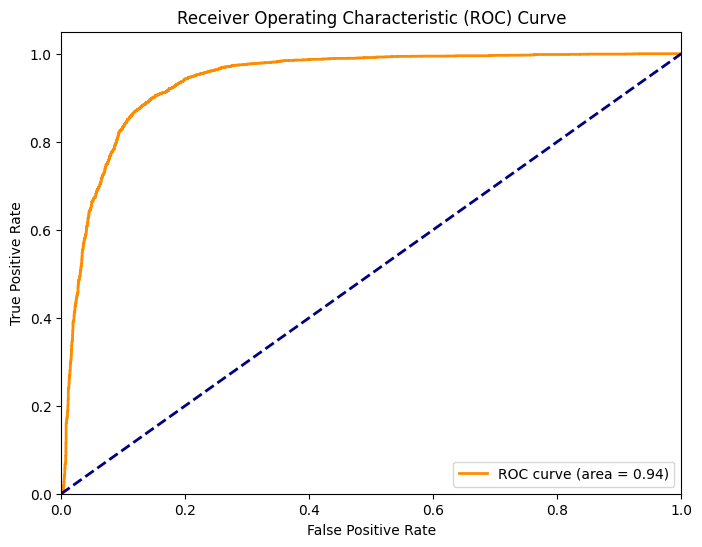

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()